<a href="https://colab.research.google.com/github/ghj-bok/test/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A7%88%EC%9D%B4%EB%8B%9D_%EA%B3%BC%EC%A0%9C_2310376(%EC%A0%95%EA%B0%95%ED%9D%AC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터마이닝 과제(2310376 정강희)
- 취업자수 증감, 실업률/고용률, 산업별/성별 취업자수 증감 replication

#### 0. Env setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
!pip install tspoon -U
import urllib
import tspoon as tsp

In [ ]:
ecos_key = 'UP2FAOS45K2DY3U1KWRV'
kosis_key = 'NzA2NjNjMTNkMzIxMDBiMzZkM2MyNTJlN2UxMjQ0Zjk='
dart_key = '01a032c1217f47668316448ce1c5f837e5d64ecc'

In [ ]:
!pip install xmltodict
from urllib.request import urlopen
import requests

import xml.etree.ElementTree as ET
import xml.dom.minidom
import xmltodict
import json

In [ ]:
def GetDataEcos(key, topic, period, beg, end, item1='', item2='', item3='', item4='', df=None, title=None):
    url = 'https://ecos.bok.or.kr/api/StatisticSearch/'+key+'/xml/kr/'+str(1)+'/'+str(1000)+'/'+topic+'/'+period+'/'+beg+'/'+end +'/'+item1+'/'+item2+'/'+item3+'/'+item4
    response = requests.get(url)
    if response.status_code == 200:
        try:
            contents = response.text
            ecosRoot = ET.fromstring(contents)
            # error check
            if ecosRoot[0].text[:4] in ("INFO","ERRO"):
                print(ecosRoot[0].text + " : " + ecosRoot[1].text)

            else:
                # print(contents)
                # dom = xml.dom.minidom.parse(xml_fname)
                dom = xml.dom.minidom.parseString(contents)
                pretty_xml_as_string = dom.toprettyxml(indent=" ")
                # print(pretty_xml_as_string)
                dic = xmltodict.parse(pretty_xml_as_string)
                n = int(dic['StatisticSearch']['list_total_count']['#text'])
                df_ecos = pd.DataFrame(index = [dic['StatisticSearch']['row'][i]['TIME'] for i in range(n)])
                df_ecos[dic['StatisticSearch']['row'][0]['ITEM_NAME1']] = [float(dic['StatisticSearch']['row'][i]['DATA_VALUE']) for i in range(n)]

                if title is not None:
                    df_ecos.columns = [title]

                if type(df)==type(pd.DataFrame()):
                    df_ecos = df.merge(df_ecos, left_index=True, right_index=True, how='left')

                return df_ecos
        except Exception as e:
                print(str(e))

In [ ]:
def GetDataKosis(key, orgid, table, beg, end, period, item, obj1='', obj2='', obj3='', obj4='', obj5='', obj6='', obj7='', obj8='', df=None, title=None, title_no='0'):
    url = 'https://kosis.kr/openapi/Param/statisticsParameterData.do?method=+&orgId='+orgid +'&tblId='+table +'&prdSe='+period \
        +'&apiKey='+key \
        +'&startPrdDe='+beg +'&endPrdDe='+end \
        +'&itmId='+item \
        +'&objL1='+obj1 +'&objL2='+obj2 \
        +'&objL3='+obj3 +'&objL4='+obj4 \
        +'&objL5='+obj5 +'&objL6='+obj6 \
        +'&objL7='+obj7 +'&objL8='+obj8 \
        +'&format=json&jsonVD=Y'

    response = requests.get(url)
    if response.status_code == 200:
        try:
            contents = response.text
            # error check
            if 'errMsg' in contents:
                print(json.loads(contents)['errMsg'])
            else:
                with urlopen(url) as url_:
                    json_file = url_.read()
                py_json = json.loads(json_file.decode('utf-8'))

                data = []
                for i, v in enumerate(py_json):
                    value = []
                    value.append(v['PRD_DE'])
                    value.append(float(v['DT']))
                    data.append(value)

                if title is not None:
                    title = str(title)
                elif str(title_no)=='0':
                    title = v['ITM_NM_ENG']
                else:
                    title = v['C'+str(title_no)+'_NM']

                df_kosis = pd.DataFrame({v['PRD_SE']:[x[0] for x in data], title:[x[1] for x in data]}).set_index(v['PRD_SE'])

                if type(df)==type(pd.DataFrame()):
                    df_kosis = df.merge(df_kosis, left_index=True, right_index=True, how='left')

                return df_kosis
        except Exception as e:
                print(str(e))

In [ ]:
urllib.request.urlretrieve("https://github.com/carpedm20/UNIST-robot/blob/master/Resources/malgun.ttf?raw=true", filename="malgun.ttf")
tsp.Hangul("malgun.ttf")

#### 1. Data Retrieval

KOSIS

1. 취업자수 증감
- 계절조정 경제활동인구 총괄(DT_1DA9001S)
- 성별 경제활동인구 총괄(DT_1DA7001S)


In [ ]:
df_kosis_emp = GetDataKosis(key=kosis_key, orgid='101', table='DT_1DA9001S', beg='201801', end='202501', period='M', item='T30+', obj1='00+', title_no=1)
df_kosis_emp_org = GetDataKosis(key=kosis_key, orgid='101', table='DT_1DA7001S', beg='201801', end='202501', period='M', item='T30+', obj1='0+', title_no=1)
df_kosis_emp = pd.merge(df_kosis_emp, df_kosis_emp_org.diff(12).dropna(), left_index=True, right_index=True, how='inner' )
df_kosis_emp.columns = ['취업자수(좌축)', '취업자수 증감(우축)']

In [ ]:
df_kosis_emp['취업자수(좌축)'] = df_kosis_emp['취업자수(좌축)']/1000
df_kosis_emp['취업자수 증감(우축)'] = df_kosis_emp['취업자수 증감(우축)']/10

In [ ]:
plt.rc('font', size=25)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=25)

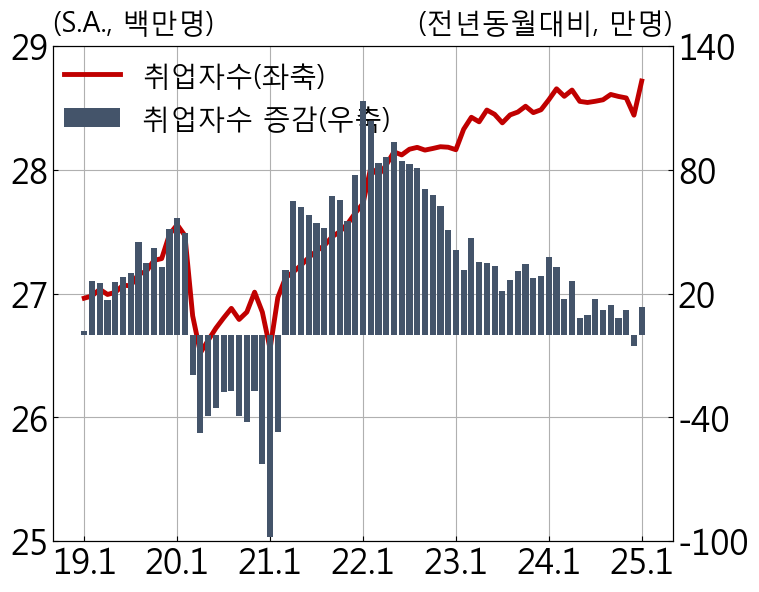

In [ ]:
fig = plt.figure(figsize=(8, 5.5))
plt.subplots_adjust(left=None, bottom=0.08, right=None, top=0.98, wspace=0, hspace=0)
plt.tight_layout()

ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()

lns2 = [ax2.bar(df_kosis_emp.index, df_kosis_emp['취업자수 증감(우축)'], color='#44546a', label='취업자수 증감(우축)')]
lns1 = ax1.plot(df_kosis_emp.index, df_kosis_emp['취업자수(좌축)'], color='#c00000', lw=3.5, label='취업자수(좌축)')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=(0,0.8), frameon=False)

ax1.set_ylim((25,29))
ax2.set_ylim((-100,140))

ax2.set_yticks(ticks=[-100,-40,20,80,140],labels=[-100,-40,20,80,140])
ax1.set_xticks(ticks=[i for i,x in enumerate(df_kosis_emp.index) if str(x)[-2:]=='01'],
               labels=[str(x)[2:4]+'.1' for i,x in enumerate(df_kosis_emp.index) if str(x)[-2:]=='01'],
               rotation=0)
ax1.tick_params(axis='x',direction='in')
ax1.tick_params(axis='y',direction='in')
ax2.tick_params(axis='y',direction='in')
ax1.grid(visible=True, which='major', axis='both')

ax1.annotate('(S.A., 백만명)', xy=(0.0, 1.03), xycoords='axes fraction', fontsize=20)
ax2.annotate('(전년동월대비, 만명)', xy=(1.0, 1.03), xycoords='axes fraction', fontsize=20, horizontalalignment='right')
plt.show()

2. 실업률 및 고용률(S.A.)
- 계절조정 경제활동인구 총괄(DT_1DA9001S)


In [ ]:
df_kosis_unemp_rate = GetDataKosis(key=kosis_key, orgid='101', table='DT_1DA9001S', beg='201901', end='202503', period='M', item='T80+', obj1='00+', title_no=1)
df_kosis_emp_rate = GetDataKosis(key=kosis_key, orgid='101', table='DT_1DA9001S', beg='201901', end='202503', period='M', item='T90+', obj1='00+', title_no=1)
df_kosis_rate = pd.merge(df_kosis_unemp_rate, df_kosis_emp_rate, left_index=True, right_index=True, how='inner' )
df_kosis_rate.columns = ['실업률(좌축)', '고용률(우축)']

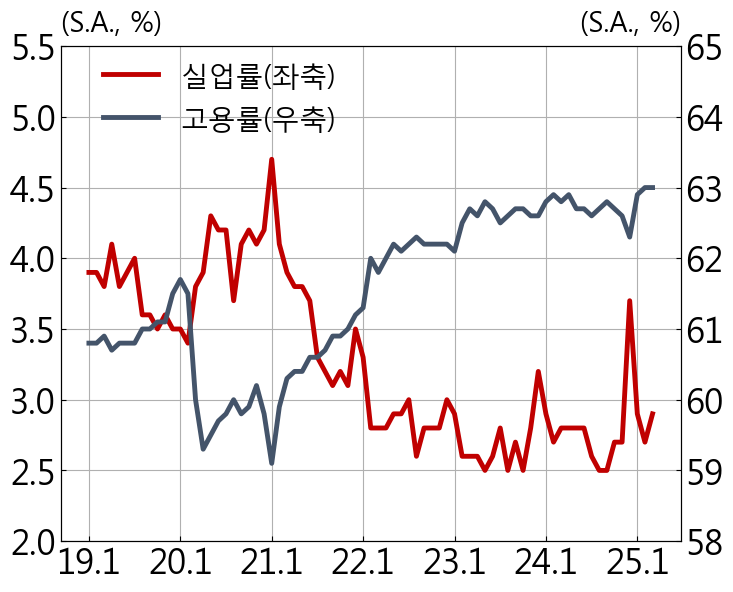

In [ ]:
fig = plt.figure(figsize=(8, 5.5))
plt.subplots_adjust(left=None, bottom=0.08, right=None, top=0.98, wspace=0, hspace=0)
plt.tight_layout()

ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()

lns2 = ax2.plot(df_kosis_emp_rate.index, df_kosis_rate['고용률(우축)'], color='#44546a', lw=3.5, label='고용률(우축)')
lns1 = ax1.plot(df_kosis_unemp_rate.index, df_kosis_rate['실업률(좌축)'], color='#c00000', lw=3.5, label='실업률(좌축)')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=(0.05,0.8), frameon=False)

ax1.set_ylim((2.0,5.5))
ax2.set_ylim((58,65))

ax2.set_yticks(ticks=range(58, 66),labels=range(58, 66))

ax1.set_xticks(ticks=[i for i,x in enumerate(df_kosis_emp.index) if str(x)[-2:]=='01'],
               labels=[str(x)[2:4]+'.1' for i,x in enumerate(df_kosis_emp.index) if str(x)[-2:]=='01'],
               rotation=0)
ax1.tick_params(axis='x',direction='in')
ax1.tick_params(axis='y',direction='in')
ax2.tick_params(axis='y',direction='in')
ax1.grid(visible=True, which='major', axis='both')

ax1.annotate('(S.A., %)', xy=(0.0, 1.03), xycoords='axes fraction', fontsize=20)
ax2.annotate('(S.A., %)', xy=(1.0, 1.03), xycoords='axes fraction', fontsize=20, horizontalalignment='right')
#ax2.annotate(str(df_1['고용률'][-1], xy=(len(df_1)-1, df_1['고용률][-1]), xytext=(len(df_1)-7),df_1['고용률][-1]))

plt.show()

3. 산업별 취업자수 증감
- 산업별 취업자(DT_1DA7E06S_NEW)

In [ ]:
#제조업(10), 건설업(41), 서비스업(00 - 01 - 04 - 35 - 41), 도소매(45), 공공행정/보건복지(84 + 86)
#서비스업 = 계(00) - 농림어업(01) - 광공업(04) - 전기가스(35) - 건설업(41)

obj1_list = ['00+', '01+', '04+', '10+', '35+', '41+', '45+', '84+', '86+']
df_kosis_emp_ind = pd.DataFrame()
for x in obj1_list:
  df_temp = GetDataKosis(key=kosis_key, orgid='101', table='DT_1DA7E06S_NEW', beg='202310', end='202501', period='M', item='T30+', obj1=x, title_no=1)
  df_kosis_emp_ind = pd.concat([df_kosis_emp_ind, df_temp], axis=1)

In [ ]:
df_kosis_emp_ind_new = pd.DataFrame()
df_kosis_emp_ind_new['제조업'] = df_kosis_emp_ind['C 제조업(10~34)']
df_kosis_emp_ind_new['건설업'] = df_kosis_emp_ind['F 건설업(41~42)']
df_kosis_emp_ind_new['서비스업'] = df_kosis_emp_ind['계'] - df_kosis_emp_ind['A 농업 임업 및 어업(01~03)'] - df_kosis_emp_ind['* 광공업(BC)'] - df_kosis_emp_ind['D 전기 가스 증기 및 공기조절 공급업(35)'] - df_kosis_emp_ind['F 건설업(41~42)']
df_kosis_emp_ind_new['도소매'] = df_kosis_emp_ind['G 도매 및 소매업(45~47)']
df_kosis_emp_ind_new['공공행정/보건복지'] = df_kosis_emp_ind['O 공공행정 국방 및 사회보장 행정(84)'] + df_kosis_emp_ind['Q 보건업 및 사회복지 서비스업(86~87)']

In [ ]:
df_kosis_emp_ind_new = df_kosis_emp_ind_new.diff(12).dropna()/10

In [ ]:
categories = df_kosis_emp_ind_new.columns
months = ['10월', '11월', '12월', '25.1월']
colors = ['#44546a', '#8faadc', '#c00000', '#ea9c9c']

df_kosis_emp_ind_new['id'] = months
df_kosis_emp_ind_long = pd.melt(df_kosis_emp_ind_new, id_vars = ['id'], var_name = '업종', value_name = '증감')

In [ ]:
import seaborn as sns

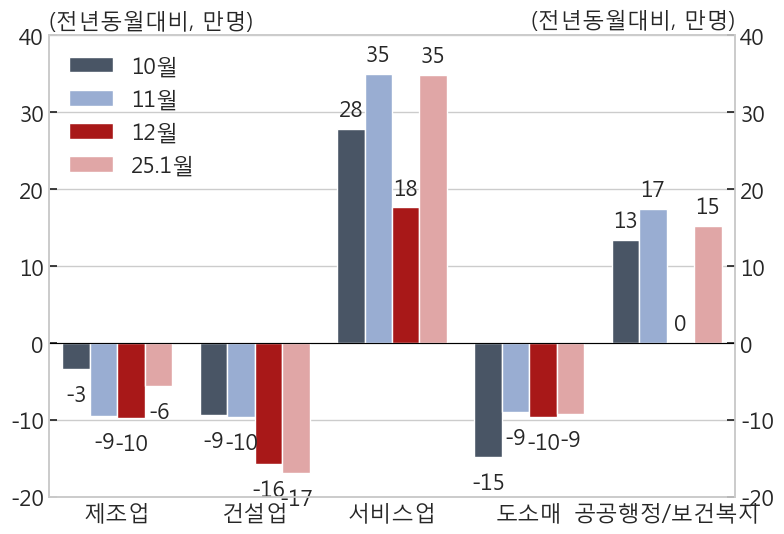

In [ ]:
sns.set(style="whitegrid", font='Malgun Gothic', rc={"axes.unicode_minus": False})
plt.figure(figsize=(8, 5.5))
업종_순서 = df_kosis_emp_ind_new.columns.drop(['id'])

ax = sns.barplot(data=df_kosis_emp_ind_long, x='업종', y='증감', hue='id', hue_order=months, palette=colors, order=업종_순서, width=0.8)
ax.set_ylim((-20, 40))
ax.tick_params(axis='x', labelsize=16, direction='in')
ax.tick_params(axis='y', labelsize=16, direction='in')
ax.legend(title='', loc='upper left', frameon=False, fontsize=16)
ax.set_ylabel('', fontsize=16)
ax.set_xlabel('', fontsize=16)

ax2 = ax.twinx()
ax2.set_ylim((-20, 40))
ax2.tick_params(axis='x', labelsize=16, direction='in')
ax2.tick_params(axis='y', labelsize=16, direction='in')

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + (1 if height >= 0 else -2),
                f'{round(height)}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=16)


plt.axhline(0, color='black', linewidth=0.8)
plt.title('(전년동월대비, 만명)', loc='left', fontsize=16)
plt.text(1, 1.02, '(전년동월대비, 만명)', transform=plt.gca().transAxes, fontsize=16, ha='right')
plt.grid(axis='y', linestyle='', color='white', alpha=0.7)
plt.tight_layout()
plt.show()

4. 성별/연령별 취업자수 증감
- 성/연령별 취업자(DT_1DA7024S)

In [ ]:
obj1_list = ['2', '3']
obj2_list = ['75', '30', '40', '50', '60']
df_kosis_emp_sex = pd.DataFrame()

for x in obj1_list:
  for y in obj2_list:
    df_temp = GetDataKosis(key=kosis_key, orgid='101', table='DT_1DA7024S', beg='201801', end='202501', period='M', item='T30+', obj1=x, obj2=y, title_no=1)
    df_temp.columns = [x+'_'+y]
    df_kosis_emp_sex = pd.concat([df_kosis_emp_sex, df_temp], axis=1)

In [ ]:
df_kosis_emp_sex['2_35'] = df_kosis_emp_sex['2_30'] + df_kosis_emp_sex['2_40'] + df_kosis_emp_sex['2_50']
df_kosis_emp_sex['3_35'] = df_kosis_emp_sex['3_30'] + df_kosis_emp_sex['3_40'] + df_kosis_emp_sex['3_50']
df_kosis_emp_sex = df_kosis_emp_sex.drop(columns=['2_30','2_40','2_50','3_30','3_40','3_50'])

In [ ]:
df_kosis_emp_sex_new = df_kosis_emp_sex.diff(12).dropna()/10
df_kosis_emp_sex_new = df_kosis_emp_sex_new[-1:]

In [ ]:
df_kosis_emp_sex_new = df_kosis_emp_sex_new[['2_75', '2_35', '2_60', '3_75', '3_35', '3_60']]
df_kosis_emp_sex_new.columns = ['청년층(남)', '핵심연령층(남)', '고령층(남)', '청년층(여)', '핵심연령층(여)', '고령층(여)']

In [ ]:
def add_label_single(bar, value):
    val_rounded = round(value, 2)
    ax.text(bar.get_x() + bar.get_width() / 2.,
            bar.get_y() + bar.get_height() if value >= 0 else bar.get_y(),
            f'{val_rounded}', ha='center', va='bottom' if value >= 0 else 'top', fontsize=10)

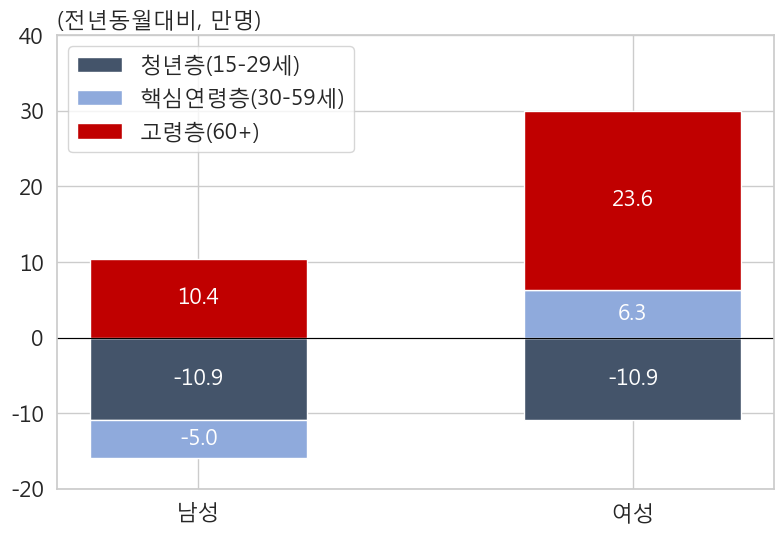

In [ ]:
labels = ['남성', '여성']
youth = df_kosis_emp_sex_new.iloc[0, [0, 3]].values
prime = df_kosis_emp_sex_new.iloc[0, [1, 4]].values
elderly = df_kosis_emp_sex_new.iloc[0, [2, 5]].values

x = np.arange(len(labels))
width = 0.6
fig, ax = plt.subplots(figsize=(8, 5.5))

bottom_prime = np.where((youth >= 0) & (prime >= 0), youth, np.where((youth < 0) & (prime < 0), youth, 0))
bottom_elderly = np.where((youth >= 0) & (prime >= 0), youth + prime, np.where((youth >= 0) & (prime < 0) & (elderly >= 0), youth, np.where((youth < 0) & (prime >=0) & (elderly >= 0), prime, 0)))

bar1 = ax.bar(x, youth, width=0.5, label='청년층(15-29세)', color='#44546a')
bar2 = ax.bar(x, prime, width=0.5, bottom=bottom_prime, label='핵심연령층(30-59세)', color='#8faadc')
bar3 = ax.bar(x, elderly, width=0.5, bottom=bottom_elderly, label='고령층(60+)', color='#c00000')

def add_label(bar_container, values):
    for bar, val in zip(bar_container, values):
        if val == 0:
            continue
        ax.text(bar.get_x() + bar.get_width() / 2.,
                bar.get_y() + bar.get_height() / 2.,
            f'{val:.1f}', ha='center', va='center', fontsize=16, color='white')

add_label(bar1, youth)
add_label(bar2, prime)
add_label(bar3, elderly)

ax.axhline(0, color='black', linewidth=0.8)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.set_ylim(-20, 40)
ax.set_yticks(np.arange(-20, 50, 10))
ax.set_yticklabels(np.arange(-20, 50, 10), fontsize=16)
ax.legend(loc='upper left', fontsize=16)

plt.title('(전년동월대비, 만명)', loc='left', fontsize=16)
plt.tight_layout()
plt.show()